      Unnamed: 0         DTime  ElapsedTime     T1  T1_time  HeaterValues
0              0  1.606163e+09     1.134222  24.13      0.0           0.0
1              1  1.606163e+09     2.463747  23.81      1.0           0.0
2              2  1.606163e+09     3.782932  23.81      2.0           0.0
3              3  1.606163e+09     5.102007  24.13      3.0           0.0
4              4  1.606163e+09     6.431441  23.81      4.0           0.0
...          ...           ...          ...    ...      ...           ...
1496        1496  1.606165e+09  2012.831449  29.29   1496.0           0.0
1497        1497  1.606165e+09  2014.150656  29.29   1497.0           0.0
1498        1498  1.606165e+09  2015.480466  29.29   1498.0           0.0
1499        1499  1.606165e+09  2016.810102  29.29   1499.0           0.0
1500        1500  1.606165e+09  2018.139608  29.29   1500.0           0.0

[1501 rows x 6 columns]


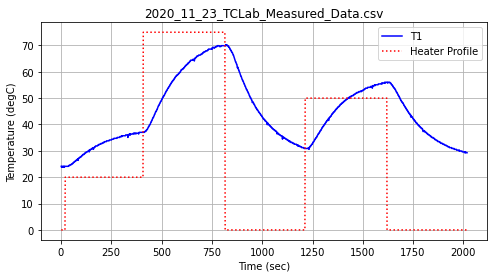

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gekko import GEKKO

%matplotlib inline
#%matplotlib widget

#from IPython.display import Markdown
#from matplotlib import rcParams
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')

CSV_FileName = '2020_11_23_TCLab_Measured_Data.csv'
#CSV_FileName = '2020_11_22_TCLab_Measured_Data.csv'
TCL = pd.read_csv(CSV_FileName)
 
print(TCL)

plt.figure(figsize=(8,4))
plt.plot(TCL.ElapsedTime, TCL.T1, color = 'blue', label = 'T1')
plt.plot(TCL.ElapsedTime, TCL.HeaterValues, color = 'red', linestyle = ':', label = 'Heater Profile')
plt.title(CSV_FileName)
plt.xlabel('Time (sec)'); plt.ylabel('Temperature (degC)'); plt.grid(True)
plt.legend()

Kp     = 0.703
Tau_p  = 189.487
thetap = 15.510


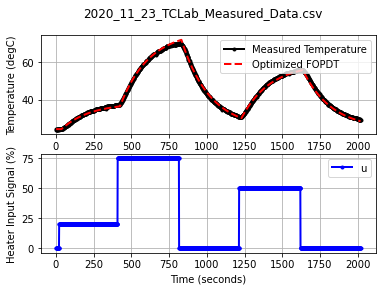

In [4]:
# GEKKO Parameter estimation

#url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
#data = pd.read_csv(url)
#t = data['time'].values - data['time'].values[0]
#u = data['u'].values
#y = data['y'].values

t = TCL.ElapsedTime.values
u = TCL.HeaterValues.values
y = TCL.T1.values

m = GEKKO(remote=False)
m.time = t
time = m.Var(0)
m.Equation(time.dt()==1)


K       = m.FV(2,  lb=0,  ub=10);      K.STATUS=1
tau     = m.FV(3,  lb=1,  ub=1000);    tau.STATUS=1
theta   = m.FV(0,  lb=0,  ub=30);      theta.STATUS=1


# create cubic spline with t versus u
uc = m.Var(u); tc = m.Var(t);

# Theta is the 'Dead Time' parameter and the 'Tc' is the 'shifted-time' array.
m.Equation(tc==time-theta)


# classmethod  cspline(x, y, x_data, y_data, bound_x=False)
# Generate a 1d cubic spline with continuous first and seconds derivatives from arrays
# of x and y data which link to GEKKO variables x and y with a constraint that y=f(x).
# Inputs:
# x: GEKKO variable
# y: GEKKO variable
# x_data: array of x data
# y_data: array of y data that matches x_data
#bound_x: boolean to state that x should be bounded at the upper and lower 
#         bounds of x_data to avoid extrapolation error of the cspline.
m.cspline(x = tc,
          y = uc,
          x_data = t,
          y_data = u,
          bound_x=False)


ym = m.Param(y) # ym is a model PARAMETER
yp = m.Var(y)   # yp is a model VARIABLE

# First-Order Plus Dead Time (FOPDT) model equation
m.Equation(tau * yp.dt() + (yp-y[0]) == K * (uc-u[0]))

# Tell the solver what to minimize.
# ... In this case the sum-of-the-squares of the Y-values (Temperature)
m.Minimize((yp-ym)**2)

m.options.IMODE=5
m.solve(disp = False)

print('Kp     = {0:.3f}'.format(K.value[0]))
print('Tau_p  = {0:.3f}'.format(tau.value[0]))
print('thetap = {0:.3f}'.format(theta.value[0]))

# These are long vectors that appear to all have the same value.
#print(K.value)
#print(tau.value)
#print(theta.value)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,y,'k.-',lw=2,label='Measured Temperature')
plt.plot(t,yp.value,'r--',lw=2,label='Optimized FOPDT')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t,u,'b.-',lw=2,label='u')
plt.legend()
plt.ylabel('Heater Input Signal (%)')
plt.xlabel('Time (seconds)')
plt.grid(True)
plt.suptitle(CSV_FileName)

plt.show()

In [3]:
# Estimated from: TCL = pd.read_csv('2020_11_22_TCLab_Measured_Data.csv')
# Kp     = 0.751
# Tau_p  = 211.029
# thetap = 12.551

# Estimated from: TCL = pd.read_csv('2020_11_23_TCLab_Measured_Data.csv')
# Kp     = 0.703
# Tau_p  = 189.487
# thetap = 15.510